<a href="https://colab.research.google.com/github/alifaisal-sadeq/Assignment-3-ISE_571/blob/main/Programming_Exercise_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       87 |      2 |             - |             -
     2 |      187 |      1 |  3.000000E+03 |         ideal
     3 |      287 |      4 |  0.000000E+00 |             f
     4 |      387 |     13 |  0.000000E+00 |             f
     5 |      487 |     25 |  0.000000E+00 |             f
     6 |      587 |     62 |  0.000000E+00 |             f
     7 |      687 |    100 |  0.000000E+00 |             f
     8 |      787 |    100 |  0.000000E+00 |             f
     9 |      887 |    100 |  0.000000E+00 |             f
    10 |      987 |    100 |  0.000000E+00 |             f
    11 |     1087 |    100 |  0.000000E+00 |             f
    12 |     1187 |    100 |  0.000000E+00 |             f
    13 |     1287 |    100 |  0.000000E+00 |             f
    14 |     1387 |    100 |  0.000000E+00 |             f
    15 |     1487 |    100 |  0.000000E+00 |             f
    16 |     1587 |    100 |  0.000000E+00 |            

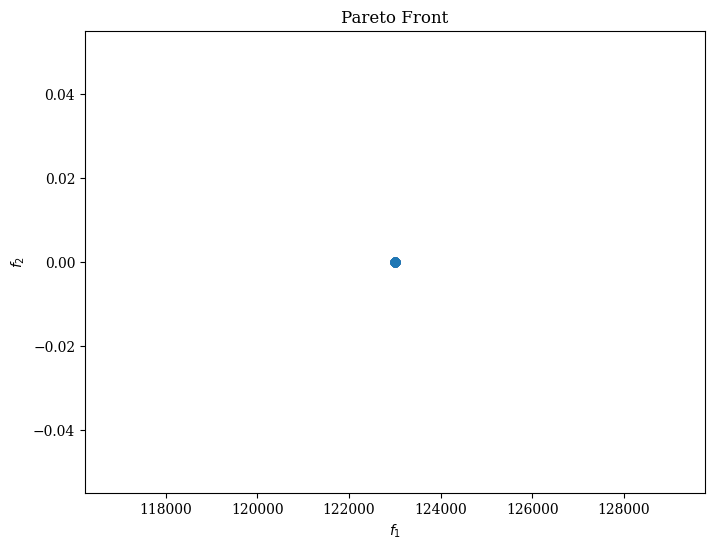

In [17]:
# Install pymoo if not already installed (run this once)
!pip install pymoo

import numpy as np
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

n_aircraft = 5
n_gates = 3
t_i = np.array([8.0, 8.5, 9.0, 10.0, 11.0])
d_i = np.array([9.0, 9.5, 10.0, 11.0, 12.0])
W_i = np.array([100, 150, 80, 120, 90])
D_xi = np.array([200, 300, 400])

class GateAssignmentProblem(ElementwiseProblem):
    def __init__(self):
        super().__init__(
            n_var=n_aircraft,
            n_obj=2,
            n_constr=0,
            xl=np.zeros(n_aircraft, dtype=int),
            xu=np.ones(n_aircraft, dtype=int) * (n_gates - 1),
            vtype=int
        )

    def _evaluate(self, x, out, *args, **kwargs):

        x = np.round(x).astype(int)

        x = np.clip(x, 0, n_gates - 1) + 1

        f1 = np.sum(W_i * D_xi[x - 1])

        f2 = 0
        for gate in range(1, n_gates + 1):

            gate_indices = np.where(x == gate)[0]
            if len(gate_indices) > 1:

                sorted_indices = gate_indices[np.argsort(t_i[gate_indices])]

                for i in range(len(sorted_indices) - 1):
                    j = sorted_indices[i]
                    k = sorted_indices[i + 1]
                    gap = t_i[k] - d_i[j]
                    f2 += max(0, gap)

        penalty = 0
        penalty_factor = 1e6
        for gate in range(1, n_gates + 1):
            gate_indices = np.where(x == gate)[0]
            if len(gate_indices) > 1:
                for i in range(len(gate_indices)):
                    for j in range(i + 1, len(gate_indices)):
                        idx1, idx2 = gate_indices[i], gate_indices[j]
                        if not (d_i[idx1] <= t_i[idx2] or d_i[idx2] <= t_i[idx1]):
                            penalty += penalty_factor


        out["F"] = [f1 + penalty, f2 + penalty]

        out["G"] = []

problem = GateAssignmentProblem()

#NSGA-II algorithm
algorithm = NSGA2(
    pop_size=100,
    sampling=IntegerRandomSampling(),
    crossover=SBX(prob=0.9, eta=15),
    mutation=PM(prob=0.1, eta=20),
    eliminate_duplicates=True
)

# Run optimization
res = minimize(
    problem,
    algorithm,
    ('n_gen', 100),
    seed=1,
    verbose=True
)

# Extract results
X = res.X
F = res.F

# results
print("\nPareto Front Solutions:")
for i in range(len(X)):
    print(f"Solution {i+1}:")
    print("Gate Assignments (x_i):", X[i] + 1)
    print("Walking Distance (f1):", F[i][0])
    print("Idle Time (f2):", F[i][1])
    print()

# Visualize the Pareto front
plot = Scatter(title="Pareto Front", xlabel="Walking Distance (m)", ylabel="Idle Time (hr)")
plot.add(F, label="Solutions")
plot.show()